In [ ]:
!nvidia-smi

Thu Nov  5 10:01:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font style="color:blue">2. Clone the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


# <font style="color:blue">3. Compile DarkNet</font>
We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [ ]:
%cd darknet

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


# <font style="color:blue">4. Download Data from Open Images Dataset</font>
Given below is the script for downloading data from open images dataset.

It downloads 2 files from Open Images. 

1. **train-annotations-bbox.csv** contains the bounding box labels for all images present in the training data of Open Images
1. **class-descriptions-boxable.csv** contains the classes which have bounding box annotations available in the dataset.

Using these 2 files we can get a list of all files corresponding to a particular class.

You can specify which classes you want to download and it will download the data. One thing to note here is that YOLO expects the bounding boxes to be in a specific format as given below.

```
<object-class> <x_center> <y_center> <width> <height>
```

The first field object-class-id is an integer representing the class of the object. It ranges from 0 to (number of classes – 1). In our current case, since we have only one class of snowman, it is always set to 0.

The second and third entry, center-x and center-y are respectively the x and y coordinates of the center of the bounding box, normalized (divided) by the image width and height respectively.

The fourth and fifth entry, width and height are respectively the width and height of the bounding box, again normalized (divided) by the image width and height respectively.

Let’s consider an example with the following notations:
```
x – x-coordinate(in pixels) of the center of the bounding box
y – y-coordinate(in pixels) of the center of the bounding box
w – width(in pixels) of the bounding box
h – height(in pixels) of the bounding box
W – width(in pixels) of the whole image
H – height(in pixels) of the whole image
```
Then we compute the annotation values in the label files as follows:
```
center-x = x / W
center-y = y / H
width = w / W
height = h / H
```
The above four entries are all floating point values between 0 to 1.

Note that the 2nd and 3rd elements are centers and NOT the top/bottom left corners. This is different from most datasets available on the internet. 

Thus, we reformat the bounding boxes according to YOLO in the last line of code in the function below.

**NOTE:** Downloading the data from aws takes considerable amount of time ( ~7 seconds per image ). Thus, we have provided a zip file for the dataset which you can download in the next cell. You can use the script to download other classes when you experiment further.

## <font style="color:blue">4.1. Download Data</font>
Download the data which we have shared using the dropbox link. This is a faster way. You can use the above process for downloading any other category.

In [ ]:
!wget "https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1" -O OID-data.zip
!mkdir OID-data
!unzip OID-data.zip -d OID-data

--2020-11-05 10:02:58--  https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip [following]
--2020-11-05 10:02:58--  https://www.dropbox.com/s/dl/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb417c0994b50f47a82f4dcb6d8.dl.dropboxusercontent.com/cd/0/get/BClEgL91Q-4Ep_tIOmg_ZXdn08ZjBu8wY75iFfup9w8QBQSq9xeMdesnwL-HJ7DNK_PL9wzWNwIZym0Tv-fmEqKsBD7xBM1de6hJZa1dL6zbwiidw3_6y-RBhh_A4JQN22k/file?dl=1# [following]
--2020-11-05 10:02:58--  https://ucb417c0994b50f47a82f4dcb6d8.dl.dropboxusercontent.com/cd/0/get/BClEgL91Q-4Ep_tIOmg_ZXdn08ZjBu8wY75iFfup9w8QBQSq9xeMdesnwL

In [ ]:
#!ls OID-data

## <font style="color:blue">4.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [ ]:
import random
import os
import subprocess
import sys

image_dir = "OID-data"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">5. Download Code for YOLO Training</font>
We have shared the code for training in the link below. Explanation of each file follows next.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GeDIS5Eb2lnbxP84YG8BlTivJHxUDiFv' -O "yolov3_mask_train.zip"
!unzip yolov3_mask_train.zip

--2020-11-06 08:15:37--  https://docs.google.com/uc?export=download&id=1GeDIS5Eb2lnbxP84YG8BlTivJHxUDiFv
Resolving docs.google.com (docs.google.com)... 172.217.5.238, 2607:f8b0:4004:808::200e
Connecting to docs.google.com (docs.google.com)|172.217.5.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jqefipc0ujp87c568knr6l0f47re3g0a/1604650500000/06131759577567716621/*/1GeDIS5Eb2lnbxP84YG8BlTivJHxUDiFv?e=download [following]
--2020-11-06 08:15:37--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jqefipc0ujp87c568knr6l0f47re3g0a/1604650500000/06131759577567716621/*/1GeDIS5Eb2lnbxP84YG8BlTivJHxUDiFv?e=download
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 172.217.15.97, 2607:f8b0:4004:811::2001
Connecting to doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleus

In [ ]:
!ls yolov3_train/*
!mv yolov3_train/* .

yolov3_train/class.names      yolov3_train/yolov3-mask-setup.data
yolov3_train/test-image1.jpg  yolov3_train/yolov3-mask_train.cfg
yolov3_train/yolov3_data.py   yolov3_train/yolov3.sh


You can see there are 4 files which have been downloaded. We will go through each file in the next section.

# <font style="color:blue">6. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [ ]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2020-11-05 10:05:13--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2020-11-05 10:05:13--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfea01ac1636d108cb7a440a458.dl.dropboxusercontent.com/cd/0/get/BCnqqcNbPP1sLnnJN9CcdtO5oy5p-z5EA8Gy4hS1TwsIrNBiU9Tf2XcHudNgbMDutDzg54zxjaVAMwmlGVWLO1dSCpCFQ2oSDoE5j3Hx7jj_wdgM60AIDLZUQMjuqUvEf7Q/file?dl=1# [following]
--2020-11-05 10:05:14--  https://ucfea01ac1636d108cb7a440a458.dl.dropboxusercontent.com/cd/0/get/BCnqqcNbPP1sLnnJN9CcdtO5oy5p-z5EA8Gy4hS1TwsIrNBiU9Tf2XcHudNgbMDutDzg54zxjaVAMwmlGVWLO1dSCpCFQ2oSD

In [ ]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qyfHrsh9HdJktzUsg6VEt3wzfTF-mgUY' -O "yolov3-mask-train_last.weights"

--2020-11-05 10:40:01--  https://docs.google.com/uc?export=download&id=1qyfHrsh9HdJktzUsg6VEt3wzfTF-mgUY
Resolving docs.google.com (docs.google.com)... 74.125.135.139, 74.125.135.100, 74.125.135.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?export=download&id=1qyfHrsh9HdJktzUsg6VEt3wzfTF-mgUY’

uc?export=download&     [ <=>                ]   3.19K  --.-KB/s    in 0s      

2020-11-05 10:40:01 (48.6 MB/s) - ‘uc?export=download&id=1qyfHrsh9HdJktzUsg6VEt3wzfTF-mgUY’ saved [3264]



# <font style="color:blue">8. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [ ]:
#!rm -rf yolov3_mask_train*

In [ ]:
!./darknet detector train yolov3-mask-setup.data yolov3-mask_train.cfg ./darknet53.conv.74 -dont_show -map 2> train_log.txt

串流輸出內容已截斷至最後 5000 行。
 Last accuracy mAP@0.5 = 84.01 %, best = 84.68 % 
 3130: 1.105090, 1.260257 avg loss, 0.001000 rate, 8.787664 seconds, 200320 images, 1.593694 hours left
Resizing, random_coef = 1.40 

 544 x 544 
 try to allocate additional workspace_size = 52.43 MB 
 CUDA allocate done! 
Loaded: 0.075017 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.5 = 84.01 %, best = 84.68 % 
 3131: 0.951254, 1.229356 avg loss, 0.001000 rate, 8.532997 seconds, 200384 images, 1.598994 hours left
Loaded: 0.000041 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.5 = 84.01 %, best = 84.68 % 
 3132: 1.267065, 1.233127 avg loss, 0.001000 rate, 8.774904 seconds, 200448 images, 1.603783 hours left
Loaded: 0.000046 seconds

 (next mAP calculation at 3200 iterations) 
 Last accuracy mAP@0.5 = 84.01 %, best = 84.68 % 
 3133: 0.939475, 1.203762 avg loss, 0.001000 rate, 8.807086 seconds, 200512 images, 1.608902 hours left
Loaded: 0.000042 seconds

 (next 

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The images are resized after every 10 iterations
It takes around 11 seconds per iteration which consists of 64 images for an image size of 576.
1. We can see that the training started very slowly in the first few iterations and then very gradually, the loss started reducing.
1. As we can see the learning rate increases gradually from 0 to 0.001 by the 100th batch ( burn_in was set to 100 ). It would stay there till the 1500th batch when it would again change to 0.0001.
1. mAP is calculated for every 100 iterations. It reaches >80% after 200 iterations.
1. You can check out the training graph for mAP v/s iterations which is saved in the file **chart.png**

# <font style="color:blue">9. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

We have written a simple utility function which can be used to display the input and output similar to what we did in the previous section

We are already familiar with the inference code which we saw in the previous section.

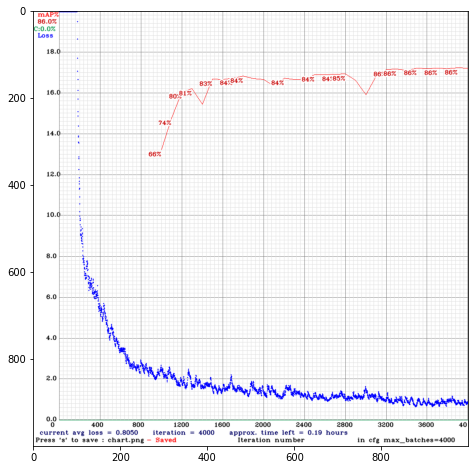

In [ ]:
src = cv2.imread("chart.png",1)

plt.figure(figsize=[20,8])
plt.subplot(121)
plt.imshow(src[:,:,::-1])

### <font style="color:green">9.1. Test Image 1</font>

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 256 K-images (4 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
test-image1.jpg: Predicted in 40.645000 milli-seconds.
Mask: 100%


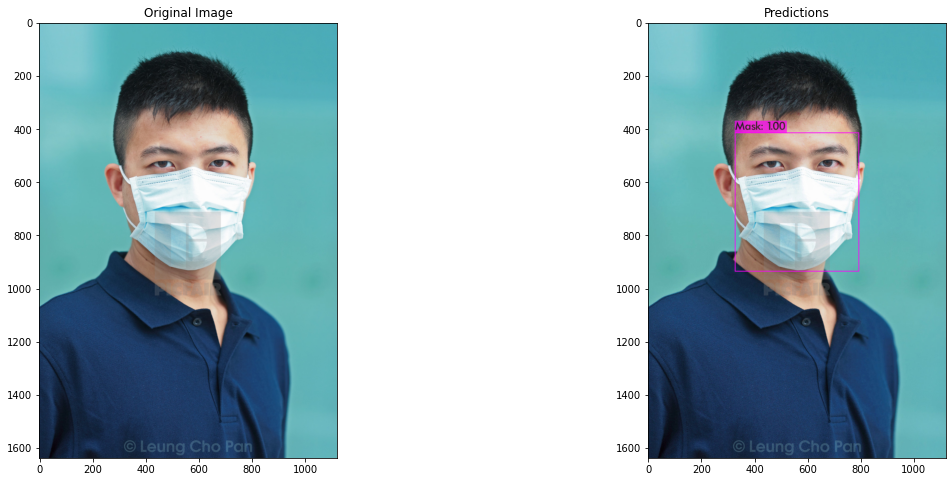

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 256 K-images (4 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
OID-data/2_Demonstration_Political_Rally_2_472.jpg: Predicted in 40.695000 milli-seconds.
No-Mask: 88%
No-Mask: 100%
No-Mask: 61%
No-Mask: 88%
No-Mask: 86%
No-Mask: 98%
No-Mask: 78%
No-Mask: 71%
No-Mask: 67%
No-Mask: 81%
No-Mask: 81%
No-Mask: 91%
No-Mask: 64%
No-Mask: 99%
No-Mask: 68%
No-Mask: 78%
No-Mask: 90%
No-Mask: 91%


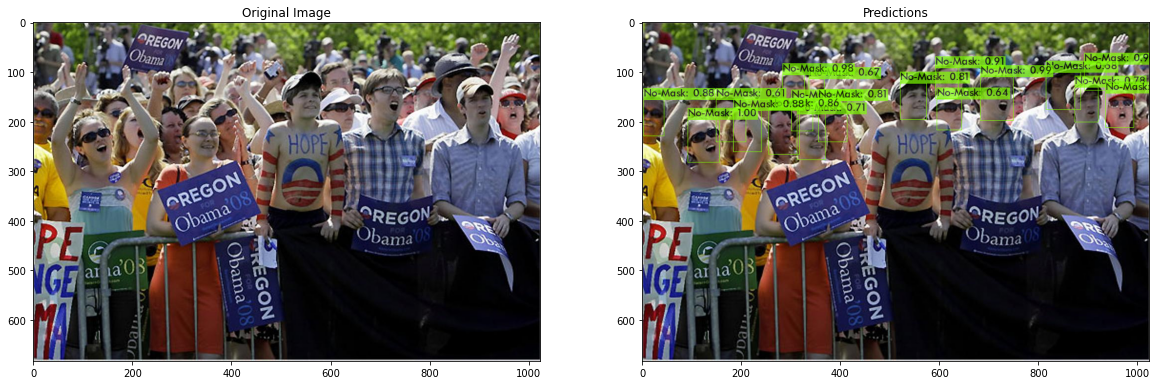

In [ ]:
!./darknet detector test yolov3-mask-setup.data yolov3-mask_test.cfg /content/darknet/backup/yolov3-mask_train_last.weights test-image1.jpg -thresh .6 2> /dev/null
display_output("test-image1.jpg")

!./darknet detector test yolov3-mask-setup.data yolov3-mask_test.cfg /content/darknet/backup/yolov3-mask_train_last.weights OID-data/2_Demonstration_Political_Rally_2_472.jpg -thresh .6 2> /dev/null
display_output("OID-data/2_Demonstration_Political_Rally_2_472.jpg")

In [ ]:
!wget "https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1" -O test-video1.mp4

--2020-11-05 10:33:11--  https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pds0w3z5y7w89oz/test-video1.mp4 [following]
--2020-11-05 10:33:11--  https://www.dropbox.com/s/dl/pds0w3z5y7w89oz/test-video1.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf964b3ccd9936e090bb966c05f.dl.dropboxusercontent.com/cd/0/get/BClK7KU_KoR9LtpmUMyJkUa9j-Xbs5PJ7SLhMtyfEf4dyJU3roGkZMy1jOPbHDGEd3nKELXOZLwkrLej84oYslK7NYX6ZvnLymaWkfMFCpysei_dZPQbHO9gL-uXDR-DAdw/file?dl=1# [following]
--2020-11-05 10:33:12--  https://ucf964b3ccd9936e090bb966c05f.dl.dropboxusercontent.com/cd/0/get/BClK7KU_KoR9LtpmUMyJkUa9j-Xbs5PJ7SLhMtyfEf4dyJU3roGkZMy1jOPbHDGEd3nKELXOZLwkrLej84oYslK7NYX6ZvnLymaWkfM

In [ ]:
!./darknet detector demo yolov3-mask-setup.data yolov3-mask_test.cfg /content/darknet/backup/yolov3-mask_train_last.weights test-video1.mp4 -thresh .6 -out_filename yolov3.avi -dont_show

串流輸出內容已截斷至最後 5000 行。
No-Mask: 100% 
No-Mask: 98% 
No-Mask: 97% 
No-Mask: 97% 
No-Mask: 93% 

FPS:35.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 98% 
No-Mask: 97% 
No-Mask: 96% 
No-Mask: 93% 

FPS:35.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 96% 
No-Mask: 96% 
No-Mask: 93% 

FPS:35.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 96% 
No-Mask: 94% 
No-Mask: 91% 

FPS:35.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 95% 
No-Mask: 95% 
No-Mask: 89% 

FPS:36.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 96% 
No-Mask: 96% 
No-Mask: 90% 
No-Mask: 86% 

FPS:36.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 97% 
No-Mask: 95% 
No-Mask: 91% 

FPS:36.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 97% 
No-Mask: 95% 
No-Mask: 90% 

FPS:37.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 98% 
No-Mask: 97% 


In [ ]:
from google.colab import files
files.download('/content/darknet/backup/yolov3-mask_train_last.weights') 